# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [106]:
# TODO: Make all necessary imports.
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time
import argparse
import pathlib

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers, models

from PIL import Image


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [107]:
# TODO: Load the dataset with TensorFlow Datasets.

(dataset_train, dataset_val, dataset_test), info = tfds.load(
    'oxford_flowers102',
    split=['train[:85%]', 'train[85%:95%]', 'train[95%:]'],
    with_info=True,
    as_supervised=True
)

# Get the number of examples in each set from our splits
num_train_examples = sum(1 for _ in dataset_train)
num_validation_examples = sum(1 for _ in dataset_val)
num_test_examples = sum(1 for _ in dataset_test)
num_classes = info.features['label'].num_classes

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")
print(f"Number of classes: {num_classes}")


Number of training examples: 867
Number of validation examples: 102
Number of test examples: 51
Number of classes: 102


In [125]:
## Explore the Dataset

In [109]:
# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = info.splits['train'].num_examples
num_validation_examples = info.splits['validation'].num_examples
num_test_examples = info.splits['test'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes

# Print the information
print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")
print(f"Number of classes: {num_classes}")


Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [110]:
# TODO: Print the shape and corresponding label of 3 images in the training set
for i, (image, label) in enumerate(dataset_train.take(3)):
    print(f"Sample {i+1}:")
    print(f"Image shape: {image.shape}")
    print(f"Label: {label.numpy()}")
    print("-" * 30)

Sample 1:
Image shape: (500, 667, 3)
Label: 72
------------------------------
Sample 2:
Image shape: (500, 666, 3)
Label: 84
------------------------------
Sample 3:
Image shape: (670, 500, 3)
Label: 70
------------------------------


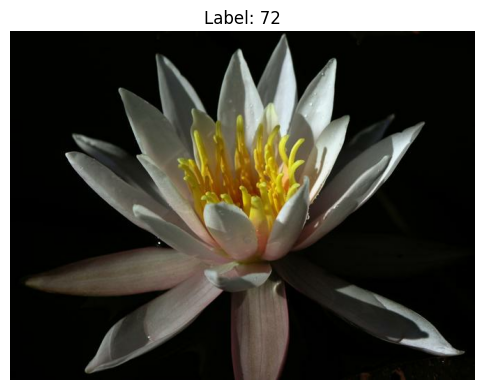

In [111]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label.

for image, label in dataset_train.take(1):
    plt.figure(figsize=(6, 6))
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [112]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

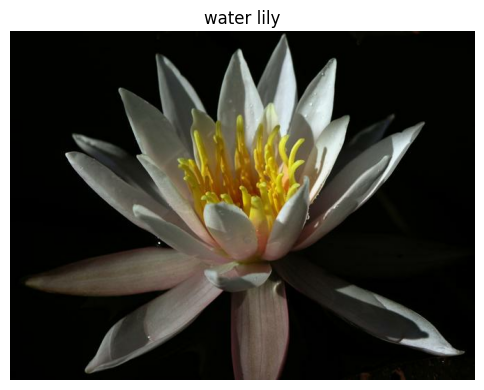

In [113]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name.

for image, label in dataset_train.take(1):
    plt.figure(figsize=(6, 6))
    plt.imshow(image.numpy())
    plt.title(class_names[str(label.numpy())])
    plt.axis('off')
    plt.show()


## Create Pipeline

In [114]:
# TODO: Create a pipeline for each set.
BATCH_SIZE = 32
IMG_SIZE = 224

def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def create_pipeline(dataset, batch_size, is_training=False):
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_pipeline = create_pipeline(dataset_train, BATCH_SIZE, is_training=True)
val_pipeline = create_pipeline(dataset_val, BATCH_SIZE)
test_pipeline = create_pipeline(dataset_test, BATCH_SIZE)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [115]:
# TODO: Build and train your network
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 10
history = model.fit(
    train_pipeline,
    epochs=EPOCHS,
    validation_data=val_pipeline
)


Epoch 1/10
28/28 [==============================] - 10s 87ms/step - loss: 4.2538 - accuracy: 0.1292 - val_loss: 3.0022 - val_accuracy: 0.2941
Epoch 2/10
28/28 [==============================] - 5s 59ms/step - loss: 1.7553 - accuracy: 0.6125 - val_loss: 1.7414 - val_accuracy: 0.5294
Epoch 3/10
28/28 [==============================] - 5s 57ms/step - loss: 0.8150 - accuracy: 0.8039 - val_loss: 1.2380 - val_accuracy: 0.6667
Epoch 4/10
28/28 [==============================] - 5s 58ms/step - loss: 0.4315 - accuracy: 0.9054 - val_loss: 1.1042 - val_accuracy: 0.6667
Epoch 5/10
28/28 [==============================] - 5s 58ms/step - loss: 0.3081 - accuracy: 0.9296 - val_loss: 1.0272 - val_accuracy: 0.7353
Epoch 6/10
28/28 [==============================] - 5s 58ms/step - loss: 0.1771 - accuracy: 0.9654 - val_loss: 0.8680 - val_accuracy: 0.7647
Epoch 7/10
28/28 [==============================] - 5s 57ms/step - loss: 0.1190 - accuracy: 0.9781 - val_loss: 0.8937 - val_accuracy: 0.7843
Epoch 8/10
2

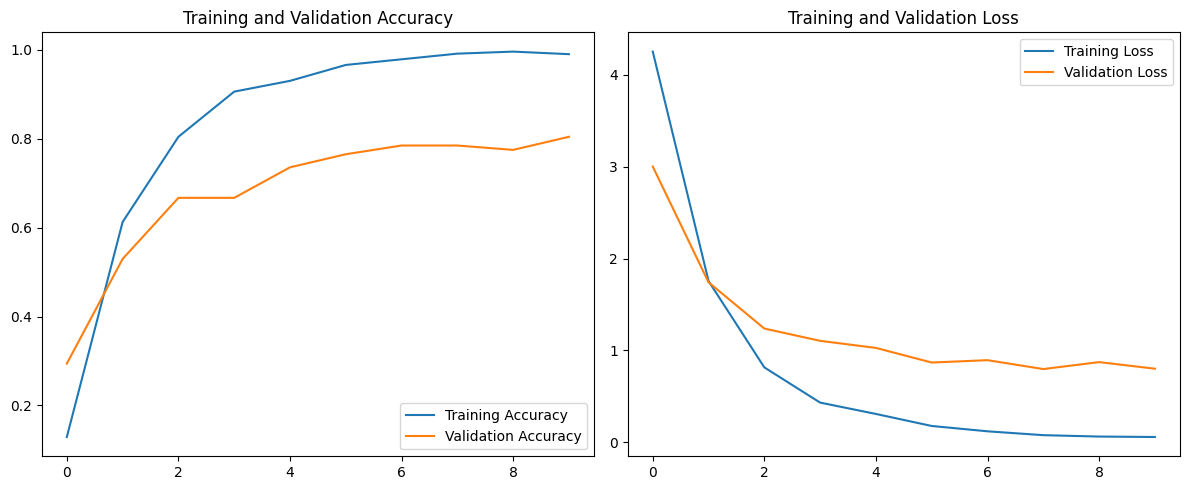

In [116]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [117]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
# We check how our model does on the test images
test_loss, test_accuracy = model.evaluate(test_pipeline)

print("\nTest Set Evaluation:")
print("-" * 40)
print(f"{'Test Loss:':<15} {test_loss:.4f}")
print(f"{'Test Accuracy:':<15} {test_accuracy:.4f}")
print("-" * 40)

# feedback about the results
if test_accuracy < 0.5:
    print("\nWarning: Model performance is low.")
elif test_accuracy < 0.7:
    print("\nModel is learning but could improve.")
else:
    print("\nGood performance! Model is working well.")


2/2 [==============================] - 0s 24ms/step - loss: 0.8720 - accuracy: 0.8039

Test Set Evaluation:
----------------------------------------
Test Loss:      0.8720
Test Accuracy:  0.8039
----------------------------------------

Good performance! Model is working well.


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [118]:
# TODO: Save your trained model as a Keras model.
model.save('flower_classifier.h5')

## Load the Keras Model

Load the Keras model you saved above.

In [119]:
# TODO: Load the Keras model
loaded_model = keras.models.load_model('flower_classifier.h5',
                                     custom_objects={'KerasLayer': hub.KerasLayer})

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [120]:
# TODO: Create the process_image function
import numpy as np
import tensorflow as tf
from PIL import Image

def process_image(image):
    """Prepares an image for our model by resizing and normalizing it"""
    # Convert to tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Resize to 224x224 while keeping the aspect ratio (adds padding if needed)
    # This is the size our model expects
    image = tf.image.resize_with_pad(image, 224, 224)
    
    # Scale the pixel values from 0-255 to 0-1 (models work better with small numbers)
    image /= 255.0
    
    # Convert back to regular numpy array before returning
    return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

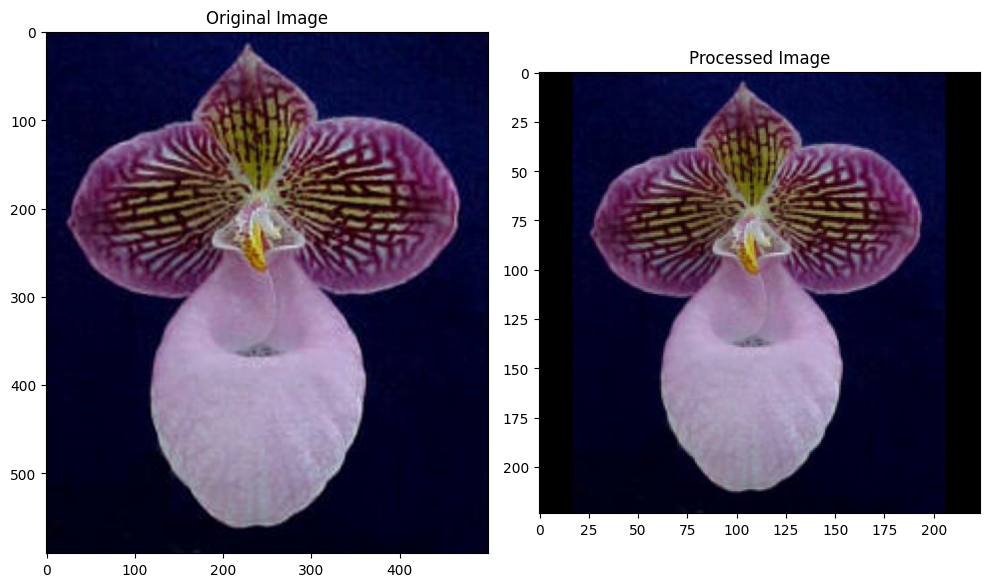

In [121]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [122]:
# TODO: Create the predict function
def predict(image_path, model, top_k=5):
    """Takes an image and returns the top K most likely flower types"""
    # Open the image file and convert it to a numpy array
    im = Image.open(image_path)
    image = np.asarray(im)
    
    # Use our process_image function to resize and normalize it
    processed_image = process_image(image)
    
    # Models expect batches of images, so we add an extra dimension
    batched_image = np.expand_dims(processed_image, axis=0)
    
    # Get the model's predictions
    predictions = model.predict(batched_image)
    
    # Find the top K predictions and their class numbers
    probs, classes = tf.math.top_k(predictions, k=top_k)
    
    # Clean up the output format:
    probs = probs.numpy().squeeze()  # Remove extra dimensions
    classes = classes.numpy().squeeze().astype(str)  # Convert to strings

    return probs, classes  # Returns probabilities and class IDs

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 1s 927ms/step


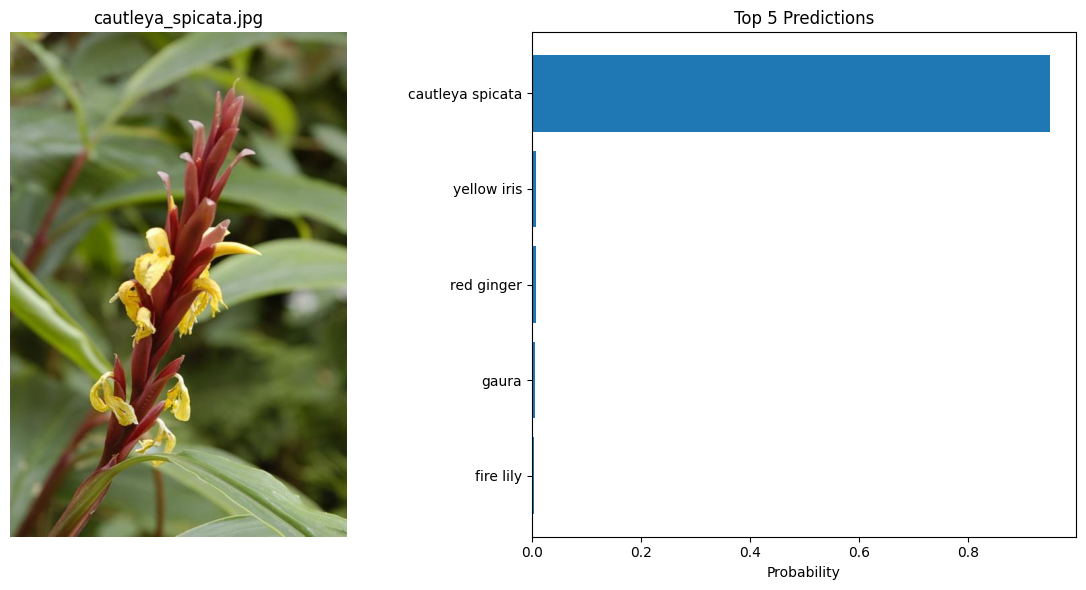

1/1 [==============================] - 0s 27ms/step


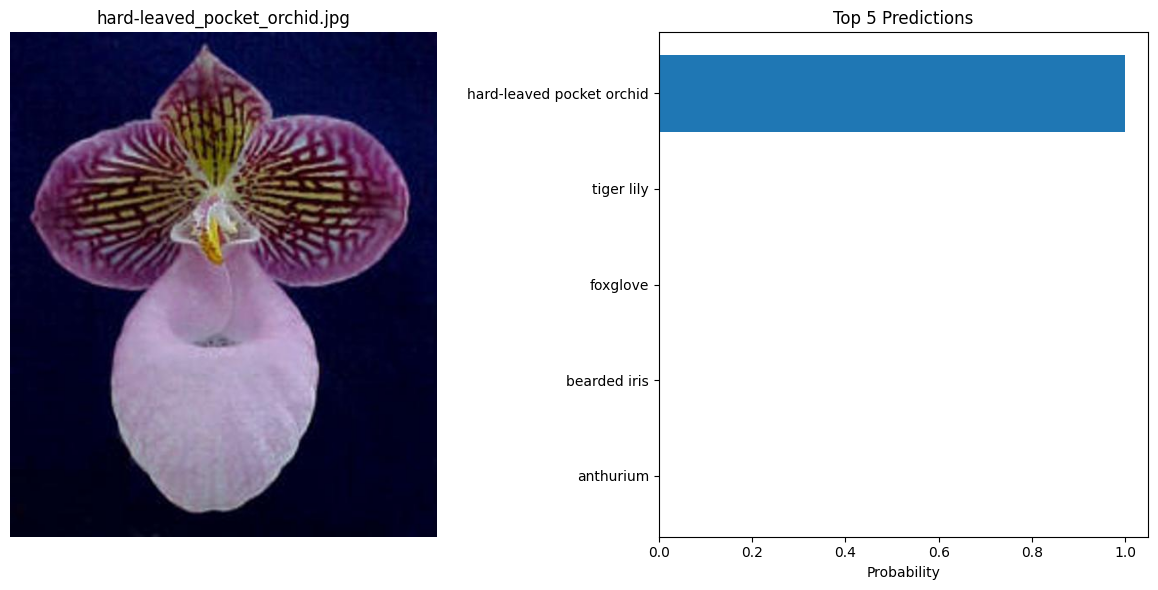

1/1 [==============================] - 0s 26ms/step


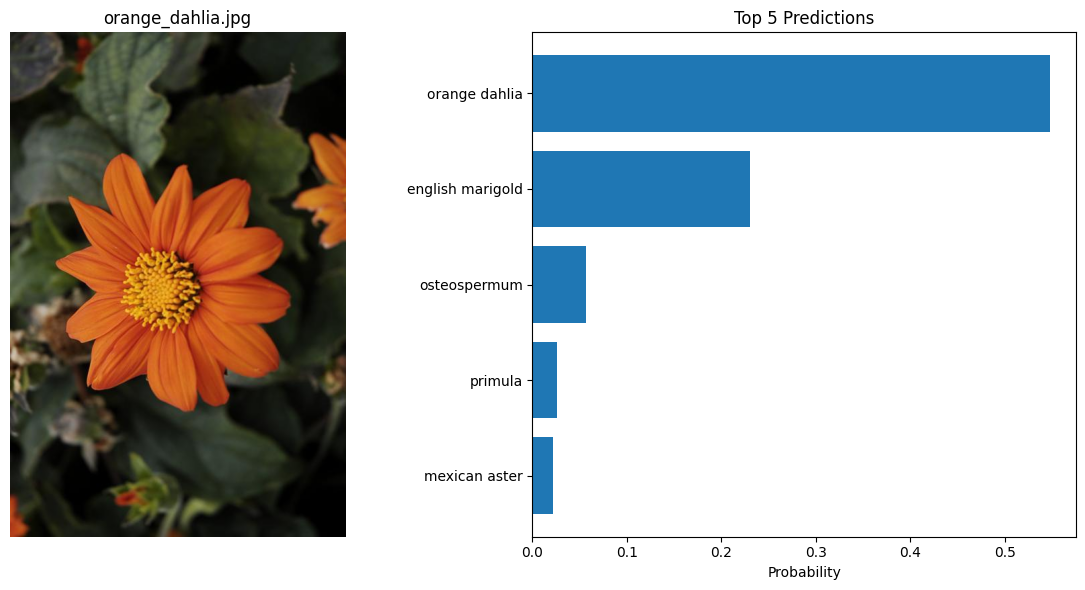

1/1 [==============================] - 0s 39ms/step


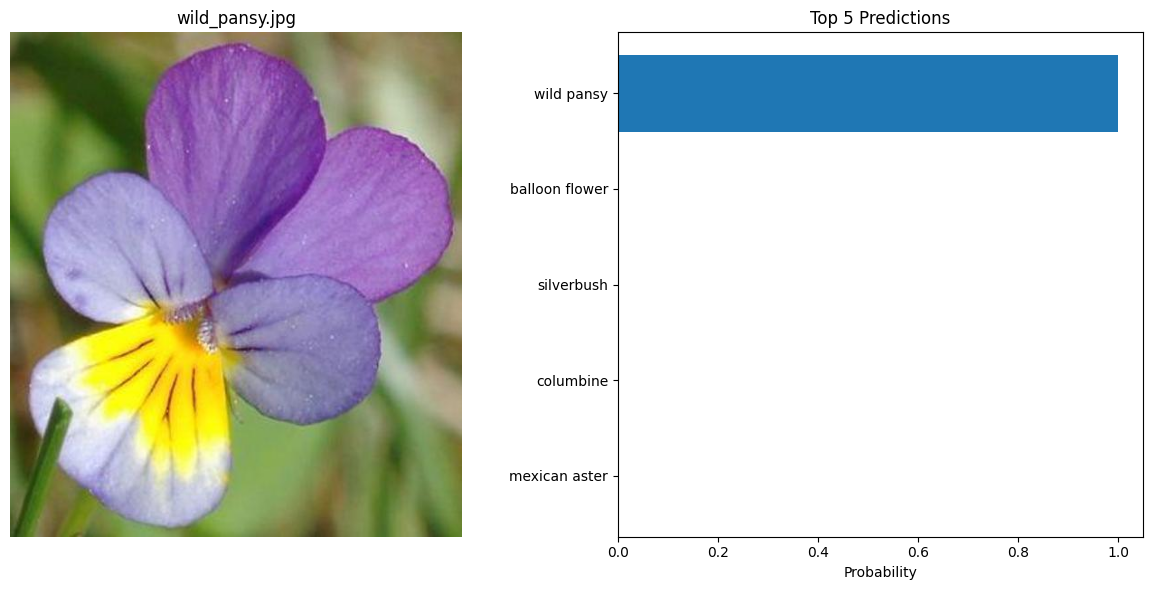

In [124]:
# TODO: Plot the input image along with the top 5 classes
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os  # Need this for getting filename

def plot_prediction(image_path, model, class_names):
    """Shows the flower image with its top 5 predicted classes"""
    # First get the predictions using our predict function
    probs, classes = predict(image_path, model, top_k=5)
    
    # Convert the class numbers to actual flower names
    flower_names = [class_names[class_id] for class_id in classes]
    
    # Set up the plot area
    plt.figure(figsize=(12, 6))  # Make it wide enough for side-by-side
    
    # Left side - show the original image
    plt.subplot(1, 2, 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axis ticks
    plt.title(os.path.basename(image_path))  # Show filename as title
    
    # Right side - create the probability bar chart
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(flower_names))  # Positions for each bar
    plt.barh(y_pos, probs, align='center', color='skyblue')
    plt.yticks(y_pos, flower_names)  # Use flower names as labels
    plt.gca().invert_yaxis()  # Put highest probability at top
    plt.xlabel('Confidence Score')
    plt.title('Model Predictions')
    plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add light grid lines
    
    # Clean up the layout
    plt.tight_layout()
    plt.show()

# Let's test this with all our sample images
test_images = [
    'cautleya_spicata.jpg',        # Test image 1
    'hard-leaved_pocket_orchid.jpg', # Test image 2 
    'orange_dahlia.jpg',            # Test image 3
    'wild_pansy.jpg'                # Test image 4
]

print("Running predictions on test images...")
for img_file in test_images:
    image_path = f'./test_images/{img_file}'
    print(f"\nAnalyzing: {img_file}")
    plot_prediction(image_path, model, class_names)